From my last project, I was able to create this graph including the top 5 counties that had the most cases and deaths in Florida. I inserted this graph just to also give a visual of the 5 counties that I was dealing with.

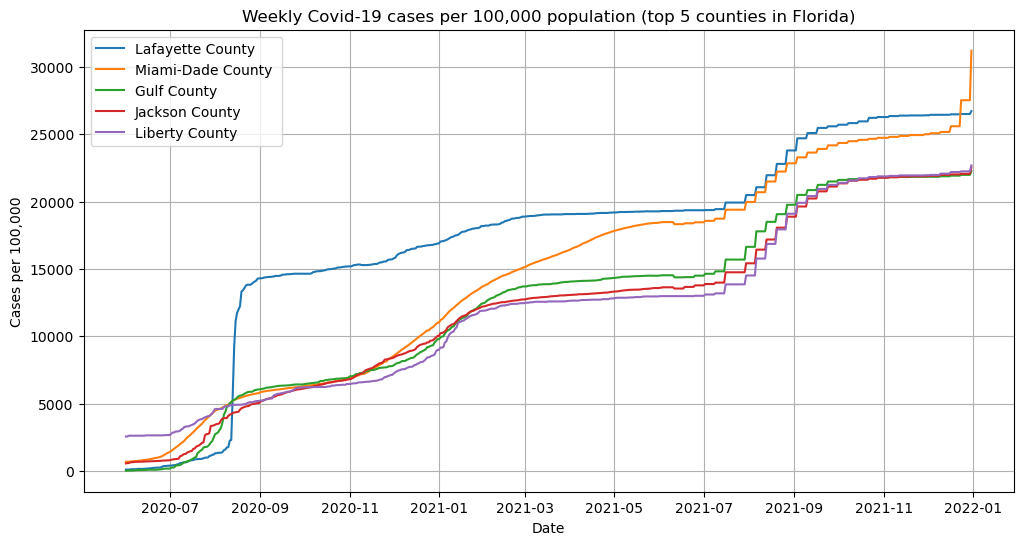

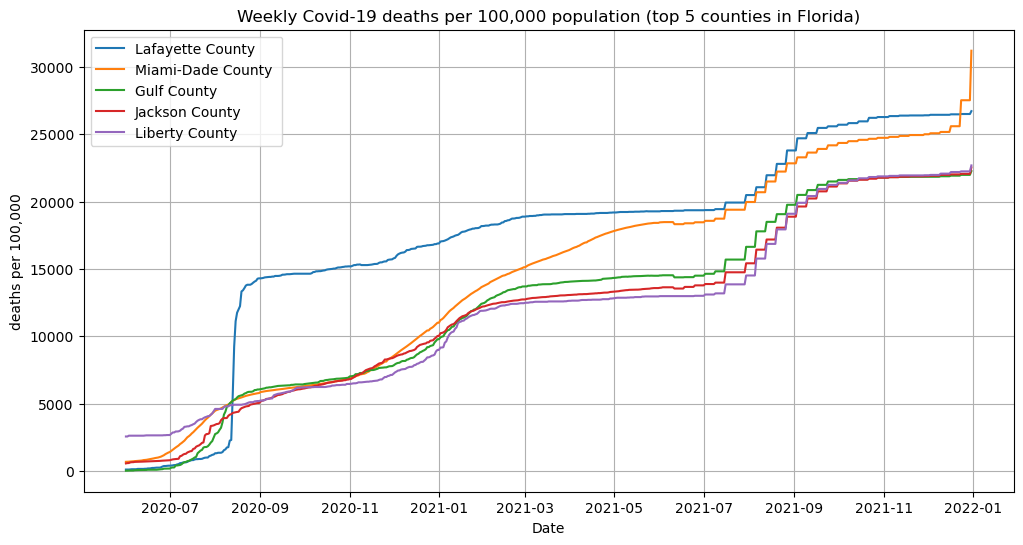

In [34]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt  
import seaborn as sns 
from scipy import stats 

#load the dataset from my 'final_merged_data.csv'
covid_super_data = pd.read_csv('final_merged_data.csv')  

start_date = '2020-06-01' 
end_date = '2021_01_03'

#start from 2020.06.01(Monday) to end date 2021.01.03(Sunday)
start_date = '2020-06-01' 
end_date = '2021_01_03' 

florida_data = covid_super_data[covid_super_data['State'] =='FL']

#get columns related to the cases
fl_cases = [col for col in florida_data.columns if '_cases' in col] 

#get columns related to the deaths
fl_deaths = [col for col in florida_data.columns if '_deaths' in col] 

#filter out only my chosen state: Florida cases. Then get relevant information such as County Name, State, Population
filtered_fl_cases= ['County Name', 'State', 'population'] + [col for col in fl_cases if start_date <= col.split('_')[0] <= end_date] 
filtered_fl_cases= florida_data[filtered_fl_cases] 

#filter out only my chosen state: Florida deaths. Then get relevant information such as County Name, State, and Population
filtered_fl_deaths= ['County Name', 'State', 'population'] + [col for col in fl_cases if start_date <= col.split('_')[0] <= end_date] 
filtered_fl_deaths= florida_data[filtered_fl_deaths]  

#use the melt function for better formatting to read the cases 
data_fl_cases = filtered_fl_cases.melt( id_vars = ['County Name', 'State', 'population'], var_name= 'date', value_name = 'cases') 

#use the melt function for better formatting to read the deaths
data_fl_deaths = filtered_fl_deaths.melt( id_vars = ['County Name', 'State', 'population'], var_name= 'date', value_name = 'deaths') 

#Convert 'date' column from a string to a datetime object 
data_fl_cases['date'] = pd.to_datetime(data_fl_cases['date'].str.split('_').str[0]) 
data_fl_deaths['date'] = pd.to_datetime(data_fl_deaths['date'].str.split('_').str[0]) 

#Group both cases and deaths by their 'State' and 'Date'
weekly_fl_cases = data_fl_cases.groupby(['County Name','date']).sum().reset_index()
weekly_fl_deaths = data_fl_deaths.groupby(['County Name','date']).sum().reset_index()  

#Start normalizing the weekly cases by the population, which we were given: (cases and deaths per 100,000 people)
weekly_fl_cases['per_100k'] = (weekly_fl_cases['cases'] / weekly_fl_cases['population']) * 100000
weekly_fl_deaths['per_100k'] = (weekly_fl_deaths['deaths'] / weekly_fl_deaths['population']) * 100000 

#This will group the weekly Florida cases data by 'county name', and get the top 5 counties
top_5_counties = weekly_fl_cases.groupby('County Name')['per_100k'].sum().nlargest(5).index.tolist() 

#filter the cases and deaths data to include only the top 5 counties
top_cases = weekly_fl_cases[weekly_fl_cases['County Name'].isin(top_5_counties)] 
top_deaths = weekly_fl_deaths[weekly_fl_deaths['County Name'].isin(top_5_counties)] 

#this will create a graph to demonstrate the weekly covid-19 cases per 100,000 population for the top 5 counties 
plt.figure(figsize=(12,6)) 
for county in top_5_counties: 
    county_data = top_cases[top_cases['County Name'] == county] 
    plt.plot(county_data['date'], county_data['per_100k'], label=county)

plt.title ('Weekly Covid-19 cases per 100,000 population (top 5 counties in Florida)') 
plt.xlabel('Date') 
plt.ylabel('Cases per 100,000') 
plt.legend() 
plt.grid(True) 
plt.show() 
 

plt.figure(figsize=(12,6)) 
for county in top_5_counties: 
    county_data = top_deaths[top_deaths['County Name'] == county] 
    plt.plot(county_data['date'], county_data['per_100k'], label=county)

plt.title ('Weekly Covid-19 deaths per 100,000 population (top 5 counties in Florida)') 
plt.xlabel('Date') 
plt.ylabel('deaths per 100,000') 
plt.legend() 
plt.grid(True) 
plt.show()  



Here I was able to find the Linear Regression for my top 5 counties in Florida. The following counties are:Lafayette, Miami-Dade, Gulf, Jackson, and Liberty. It appeared to be that for most counties, the graphs demonstrated to have a strong linear regression. I would say that Lafayette county possibly contained a couple of outliers.

Linear RMSE for Lafayette County  : 3213.5337520440607


<Figure size 1400x800 with 0 Axes>

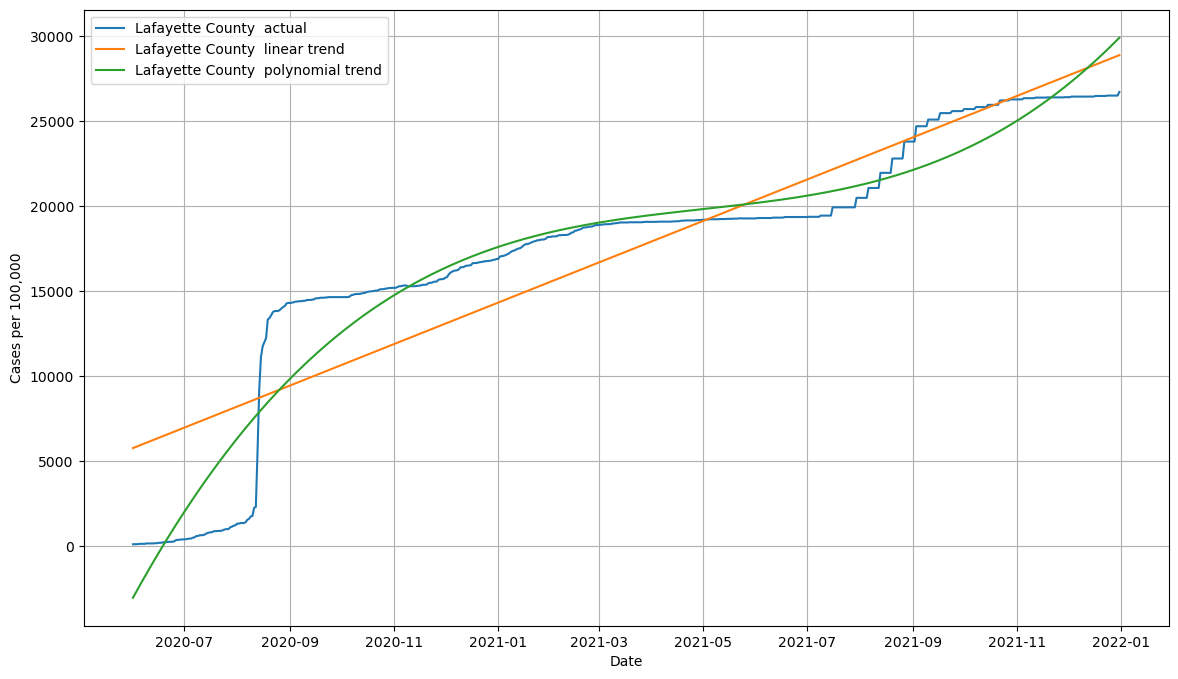

Linear RMSE for Miami-Dade County  : 962.4406410709404


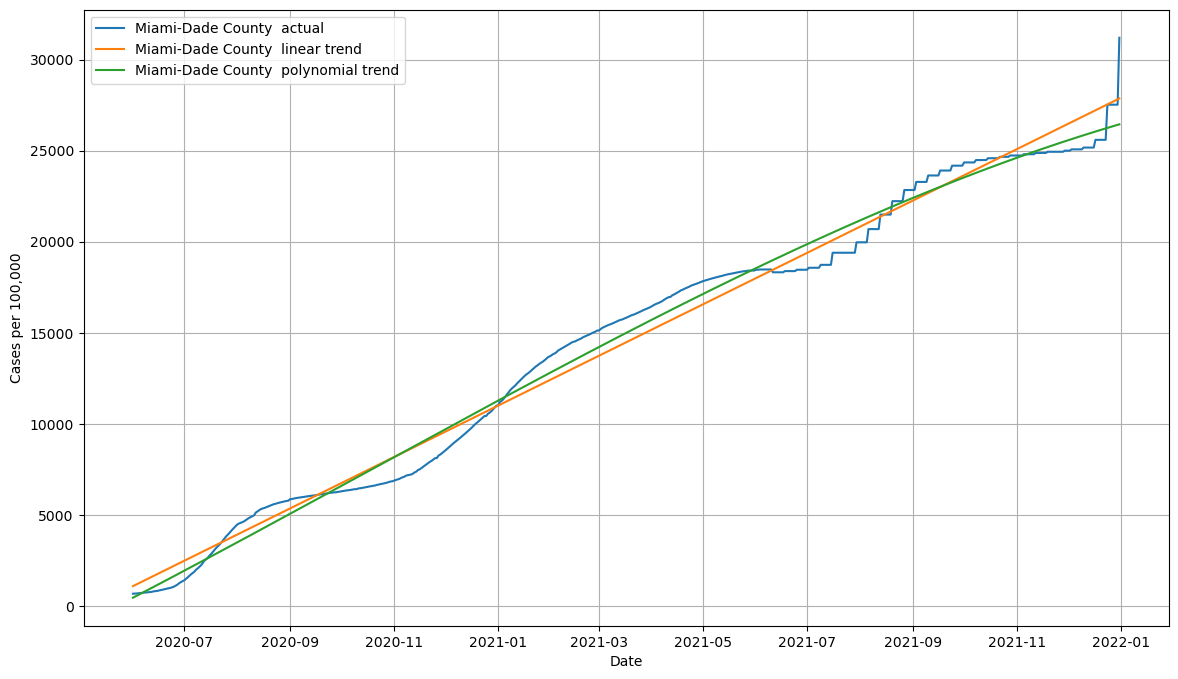

Linear RMSE for Gulf County  : 1213.1297960141812


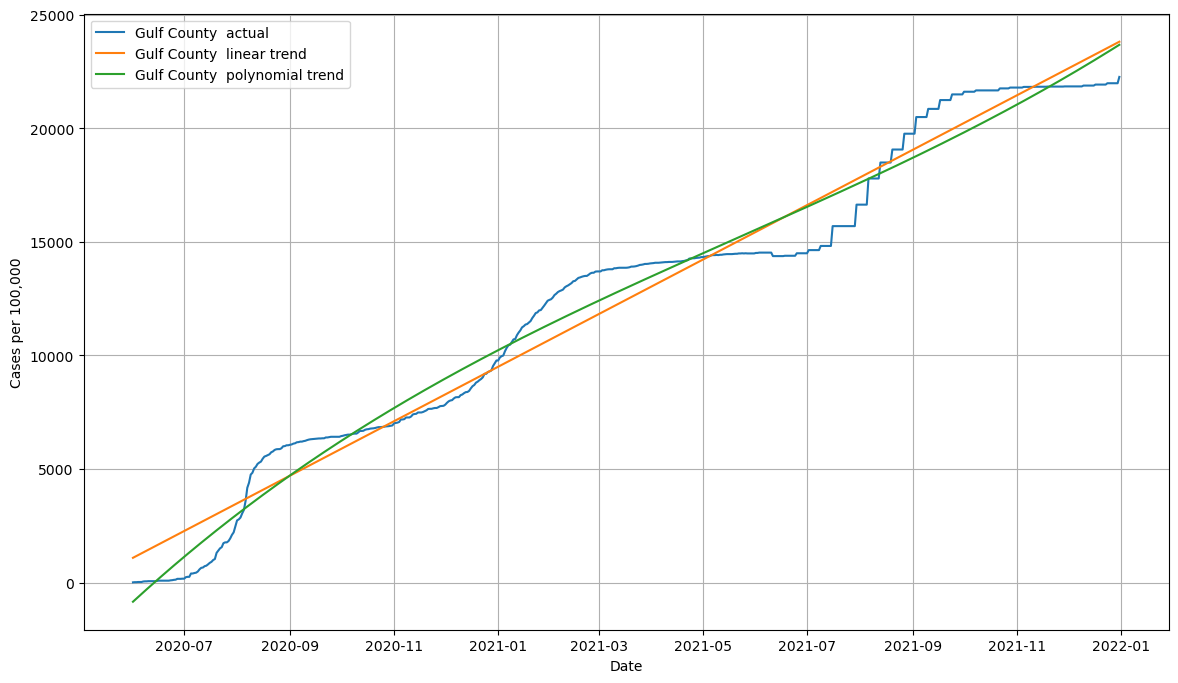

Linear RMSE for Jackson County  : 1130.4690066293003


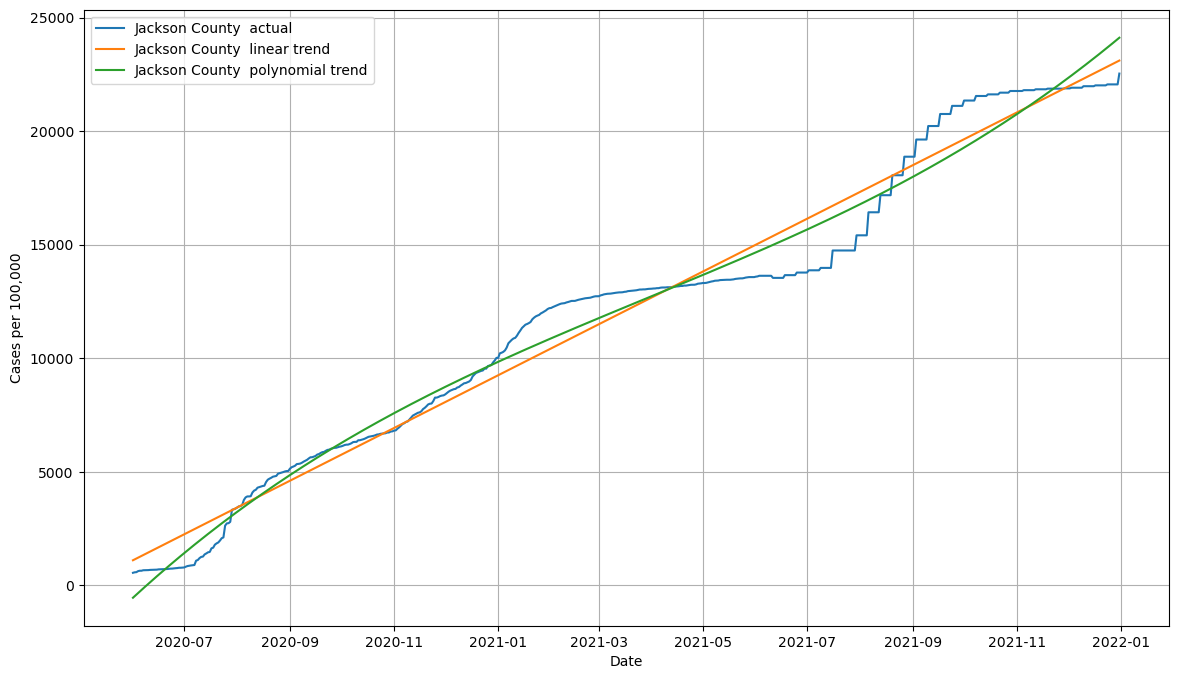

Linear RMSE for Liberty County  : 1300.9750810214277


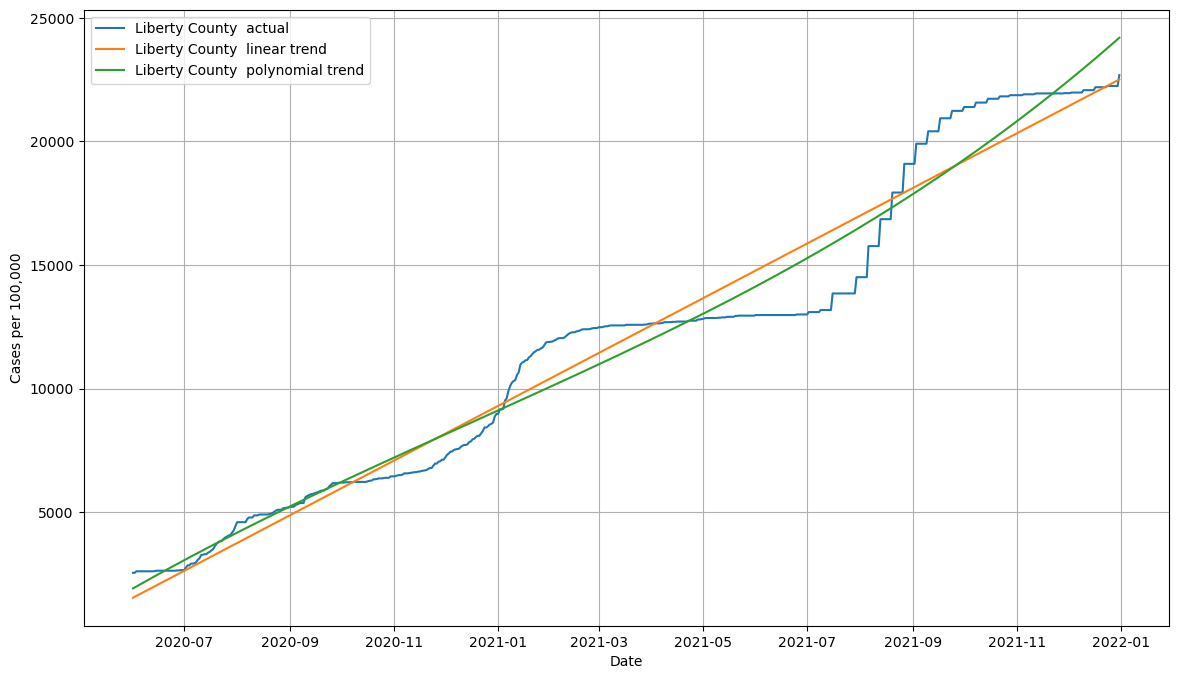

In [76]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error  
from scipy import stats
import numpy as np  

plt.figure(figsize=(14,8))
for county in top_5_counties: 
    county_data = top_cases[top_cases['County Name'] == county] 
    X = np.array((county_data['date'] - county_data['date'].min()).dt.days).reshape(-1,1) 
    y = county_data['per_100k'].values 

    linear_model = LinearRegression().fit(X,y) 
    y_pred_linear = linear_model.predict(X)  

    poly_features = PolynomialFeatures(degree=3) 
    X_poly = poly_features.fit_transform(X) 
    poly_model = LinearRegression().fit(X_poly, y) 
    y_pred_poly = poly_model.predict(X_poly)
    

    rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear)) 
    print(f"Linear RMSE for {county} : {rmse_linear}") 

    plt.figure(figsize=(14,8))
    plt.plot(county_data['date'], y, label=f"{county} actual") 
    plt.plot(county_data['date'], y_pred_linear, label=f"{county} linear trend")  
    plt.plot(county_data['date'], y_pred_poly, label=f"{county} polynomial trend")

    plt.xlabel("Date") 
    plt.ylabel("Cases per 100,000") 
    plt.legend() 
    plt.grid(True) 
    plt.show()


Here we can see that I was able to find the Polynomial Regression for my top 5 counties. From polynomial regressions, it can provide more accurate prediction about our data. As I have previously mentioned, it seemed that Lafayette appeared to have a couple of outliers. However, they were not as noticeable in the linear regression. However, in the Polynomial Regression, we can see that Lafayette County does appear to have a couple of outliers based on the way our polynomial trend looks like.

Polynomial RMSE for Lafayette County : 1934.2316486898626
Polynomial RMSE for Miami-Dade County : 830.8787187830741
Polynomial RMSE for Gulf County : 1066.5437710931153
Polynomial RMSE for Jackson County : 999.9267121203849
Polynomial RMSE for Liberty County : 1189.1159587546424


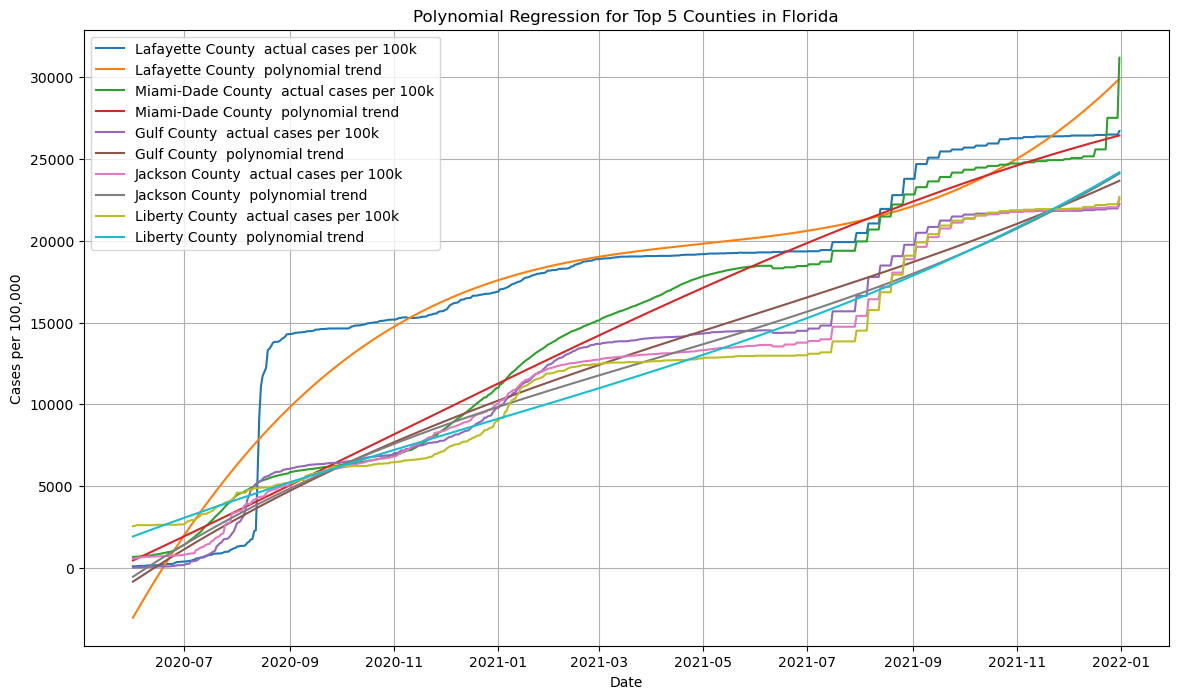

In [72]:
from sklearn.preprocessing import PolynomialFeatures 

plt.figure(figsize=(14,8))
for county in top_5_counties: 
    county_data = top_cases[top_cases['County Name'] == county] 
    X = np.array((county_data['date'] - county_data['date'].min()).dt.days).reshape(-1,1) 
    y = county_data['per_100k'].values 

    poly_features = PolynomialFeatures(degree=3) 
    X_poly = poly_features.fit_transform(X) 
    poly_model = LinearRegression().fit(X_poly, y) 
    y_pred_poly = poly_model.predict(X_poly) 

    rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly)) 
    print(f"Polynomial RMSE for {county}: {rmse_poly}") 

    plt.plot(county_data['date'], y, label=f"{county} actual cases per 100k") 
    plt.plot(county_data['date'],y_pred_poly, label=f"{county} polynomial trend") 

plt.xlabel("Date") 
plt.ylabel("Cases per 100,000") 
plt.title("Polynomial Regression for Top 5 Counties in Florida") 
plt.legend() 
plt.grid(True) 
plt.show()

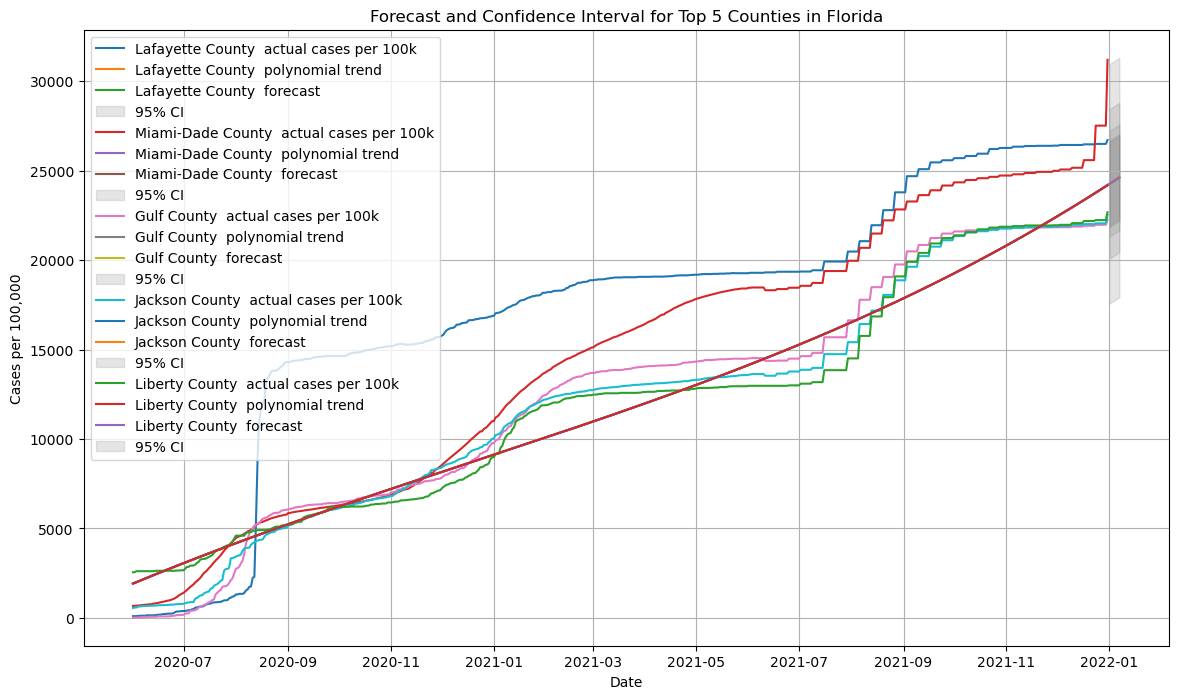

In [74]:
import scipy.stats as stats 

forecast_days = 7 
future_X = np.array(range(X[-1][0] + 1, X[-1][0] + 1 + forecast_days)).reshape(-1,1) 
future_X_poly = poly_features.transform(future_X) 

plt.figure(figsize=(14,8))
for county in top_5_counties: 
    county_data = top_cases[top_cases['County Name'] == county] 
    X = np.array((county_data['date'] - county_data['date'].min()).dt.days).reshape(-1,1) 
    y = county_data['per_100k'].values 

    y_pred = poly_model.predict(X_poly) 
    residuals = y - y_pred  
    std_error = np.std(residuals) 

    y_forecast = poly_model.predict(future_X_poly) 

    ci = stats.norm.interval(0.95, loc=y_forecast, scale=std_error) 

    plt.plot(county_data['date'], y, label=f"{county} actual cases per 100k") 
    plt.plot(county_data['date'], y_pred, label=f"{county} polynomial trend") 
    plt.plot(pd.date_range(county_data['date'].max() + pd.Timedelta(days=1), periods=forecast_days), y_forecast, label=f"{county} forecast") 
    plt.fill_between(pd.date_range(county_data['date'].max() + pd.Timedelta(days=1), periods=forecast_days), ci[0], ci[1], color='gray', alpha=0.2, label="95% CI") 

plt.xlabel("Date")  
plt.ylabel("Cases per 100,000") 
plt.title("Forecast and Confidence Interval for Top 5 Counties in Florida") 
plt.legend() 
plt.grid(True) 
plt.show()

In [138]:
import pandas as pd

# Load the data into DataFrames
social_data = pd.read_csv('ACSDP5Y2020.DP02-Data.csv')
social_data_df = pd.DataFrame(social_data)  
covid_data = pd.read_csv('final_merged_data.csv')
covid_data_df = pd.DataFrame(covid_data) 

# Update column headers and clean up data
social_data_df.columns = social_data_df.iloc[0]
social_data_df = social_data_df.drop(0)
social_data_df = social_data_df.reset_index(drop=True)

# Rename the 'Geography' column to 'countyFIPS'
new_column_name = 'countyFIPS'
social_data_df = social_data_df.rename(columns={'Geography': new_column_name})

# Extract the relevant FIPS code from 'countyFIPS' column
social_data_df['countyFIPS'] = social_data_df['countyFIPS'].str[9:]  

# Convert 'countyFIPS' to integer type
social_data_df['countyFIPS'] = social_data_df['countyFIPS'].astype(int)

# Merge the data on 'countyFIPS' column
merged_data = pd.merge(covid_data_df, social_data_df, on='countyFIPS', how='outer')

# Display the merged data
merged_data.head()  



C:\Users\jenny\AppData\Local\Temp\ipykernel_58696\3565803026.py:4: DtypeWarning: Columns (2,3,4,5,8,9,12,13,16,17,18,19,20,21,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,250,251,252,253,254,255,256,257,258,259,260,261,262,263,26

,countyFIPS,County Name,State,StateFIPS_cases,2020-01-22_cases,2020-01-23_cases,2020-01-24_cases,2020-01-25_cases,2020-01-26_cases,2020-01-27_cases,...,Percent Margin of Error!!ANCESTRY!!Total population!!Welsh,Percent!!ANCESTRY!!Total population!!West Indian (excluding Hispanic origin groups),Percent Margin of Error!!ANCESTRY!!Total population!!West Indian (excluding Hispanic origin groups),Percent!!COMPUTERS AND INTERNET USE!!Total households,Percent Margin of Error!!COMPUTERS AND INTERNET USE!!Total households,Percent!!COMPUTERS AND INTERNET USE!!Total households!!With a computer,Percent Margin of Error!!COMPUTERS AND INTERNET USE!!Total households!!With a computer,Percent!!COMPUTERS AND INTERNET USE!!Total households!!With a broadband Internet subscription,Percent Margin of Error!!COMPUTERS AND INTERNET USE!!Total households!!With a broadband Internet subscription,NaN
0,1001,Autauga County,AL,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.0,0.1,21559,(X),91.4,1.0,82.7,1.8,NaN
1,1003,Baldwin County,AL,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,84047,(X),91.8,0.8,85.1,1.2,NaN
2,1005,Barbour County,AL,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,1.4,1.0,9322,(X),79.8,2.6,64.6,3.5,NaN
3,1007,Bibb County,AL,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.2,0.0,0.2,7259,(X),83.2,3.8,76.1,3.4,NaN
4,1009,Blount County,AL,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.0,0.1,21205,(X),85.0,1.7,79.6,2.1,NaN


In [104]:
# household data for total households in a county

household_data = merged_data[['countyFIPS', 'State', 'County Name', 'Estimate!!HOUSEHOLDS BY TYPE!!Total households']]
household_data = household_data[household_data['State'] == 'FL'].dropna()

household_data

,countyFIPS,State,County Name,Estimate!!HOUSEHOLDS BY TYPE!!Total households
322,12001,FL,Alachua County,101979
323,12003,FL,Baker County,8828
324,12005,FL,Bay County,73536
325,12007,FL,Bradford County,9318
326,12009,FL,Brevard County,236005
...,...,...,...,...
384,12125,FL,Union County,4008
385,12127,FL,Volusia County,220386
386,12129,FL,Wakulla County,11382
387,12131,FL,Walton County,28635


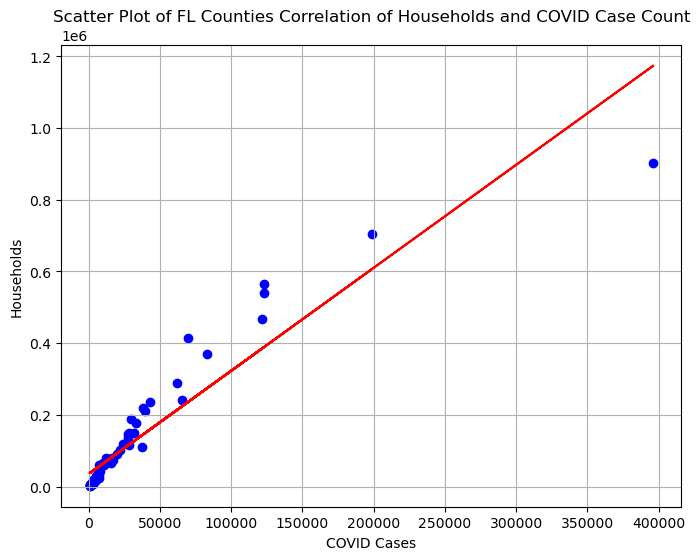

In [106]:

# Define the date columns related to COVID cases in your data
# Replace '2020-01-22' and '2023-07-23' with your actual start and end dates if different
cases_dates = [col for col in covid_data_df.columns if '2020-01-22' <= col <= '2023-07-23']

counties = household_data['countyFIPS']
plt.figure(figsize=(8, 6))

county_mean_array = []
county_households_array = []

# Iterate through each of the counties and plot the county covid sum and county household on a scatter plot
for i in counties:
    county_df = covid_data_df[covid_data_df['countyFIPS'] == i]
    county_cases_df = county_df[cases_dates]
    county_cases_array = county_cases_df.values.flatten()

    county_mean = county_cases_array.mean()
    
    county_households = household_data[household_data['countyFIPS'] == i]['Estimate!!HOUSEHOLDS BY TYPE!!Total households'].astype(int)

    county_mean_array.append(county_mean)
    county_households_array.append(county_households)

    plt.scatter(county_mean, county_households, color='blue', marker='o')

# Plot the line of best fit for the correlation
m, b = np.polyfit(county_mean_array, county_households_array, 1)
plt.plot(county_mean_array, m*county_mean_array + b, 'r-')
    
plt.xlabel('COVID Cases')  
plt.ylabel('Households') 
plt.title('Scatter Plot of FL Counties Correlation of Households and COVID Case Count')
plt.grid(True)
plt.show()  

**Hypothesis** 

*1) Higher total number of households in a county is associated with higher COVID-19 cases* 

*2)A higher percentage of households with internet will correlate with slower COVID-19 spread* 
 
*3) Counties with larger households (more members) have higher COVID-19 case counts* 


In [158]:
from scipy.stats import ttest_ind

household_data['Estimate!!HOUSEHOLDS BY TYPE!!Total households'] = pd.to_numeric( 
    household_data['Estimate!!HOUSEHOLDS BY TYPE!!Total households'], errors='coerce' 
) 
hypotheses= [ 
    ("Higher total households associated with higher COVID-19 cases", 'Estimate!!HOUSEHOLDS BY TYPE!!Total households'), 
] 

total_cases = covid_data_df.groupby('countyFIPS')[cases_dates].sum().reset_index() 
total_cases['total_cases'] = total_cases[cases_dates].sum(axis=1) 

median_cases = total_cases['total_cases'].median() 
low_case_counties = total_cases[total_cases['total_cases'] <= median_cases]['countyFIPS'] 
high_case_counties = total_cases[total_cases['total_cases'] > median_cases]['countyFIPS'] 

low_case_households = household_data[household_data['countyFIPS'].isin(low_case_counties)] 
high_case_households = household_data[household_data['countyFIPS'].isin(high_case_counties)] 

results = [] 
for hypothesis, col_name in hypotheses: 
    if len(low_case_households) > 0 and len(high_case_households) > 0: 
        t_stat_two_tail, p_value_two_tail = ttest_ind( 
            low_case_households[col_name], high_case_households[col_name], alternative='two-sided' 
        ) 
        two_stat_one_tail, p_value_one_tail = ttest_ind( 
            low_case_households[col_name], high_case_households[col_name], alternative='less' 
        ) 
        results.append({ 
            "Hypothesis": hypothesis,
            "Column": col_name, 
            "Two-Tail T-Statistic": t_stat_two_tail, 
            "Two-Tail P-Value" : p_value_two_tail,
            "One-Tail T-Statistic": t_stat_one_tail, 
            "One-Tail P-Value": p_value_one_tail 
        }) 
    else: 
        print(f"Insufficient data for hypothesis: {hypothesis}") 

for result in results: 
    print(f"Hypothesis: {result['Hypothesis']}")  
    print(f"T-Statistic (Two-Tailed): {result['Two-Tail T-Statistic']}, P-value: {result['Two-Tail P-Value']}") 
    print(f"T-Statistic (One-Tailed): {result['One-Tail T-Statistic']}, P-value: {result['One-Tail P-Value']}") 
    print("-" * 50)


Hypothesis: Higher total households associated with higher COVID-19 cases
T-Statistic (Two-Tailed): -2.6771950193970486, P-value: 0.009388394188873184
T-Statistic (One-Tailed): -2.6771950193970486, P-value: 0.004694197094436592
--------------------------------------------------
